In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

# Convolutions

* Repaso de trabajo con imagenes

## Dataset de imagenes

* CIFAR-10: clasico de computer vision
* consiste de 60,000 imagenes de 32x32 a color (RGB), etiquetadas con un entero que corresponde a 10 clases:
    * 0 - avion
    * 1 - carro
    * 2 - pajaro
    * 3 - gato
    * 4 - venado
    * 5 - perro
    * 6 - sapo
    * 7 - caballo
    * 8 - barco
    * 9 - camion
    
* las imagenes fueron recolectadas y etiquetadas por Krizhevsky, Nair y Hinton de CIFAR (Canadian Institute for Advanced Research)
* son un subset de una coleccion mas grande de imagenes a color de 32x32 no etiquetadas
    * "80 million tiny images dataset"
    * CSAIL (Computer Science and Artificial Intelligence Laboratory) de MIT
* Ya es considerada demasiado simple

### Descargar CIFAR10

In [1]:
from torchvision import datasets

data_path = "../data/cifar10/"

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

0it [00:00, ?it/s]

100%|█████████▉| 170434560/170498071 [01:40<00:00, 1761194.10it/s]

Files already downloaded and verified


170500096it [02:00, 1761194.10it/s]                               

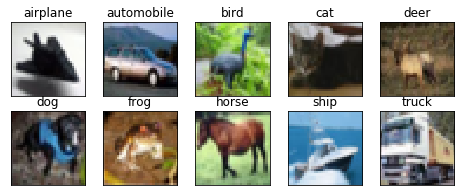

In [12]:
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

fig = plt.figure(figsize=(8,3))
num_classes = 10

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

* El modulo de `datasets` nos da acceso a los datasets de computer vision mas populares:
    * MNIST
    * FashionMNIST
    * CIFAR-100
    * SVHN
    * Coco
    * Omniglot
* En todos los casos son retornados como subclases de `torch.utils.data.Dataset`.
* Podemos ver que el _method resolution order_ de nuestra instancia `cifar10` lo incluye como su clase base

In [3]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 object)

### La clase Dataset

* Un Dataset de PyTorch es un objeto que requiere que se implementen dos metodos:
    * `__len__`: debe retornar el  numero de items en el dataset
    * `__getitem__`: debe retornar el item, consistiendo de una muestra y su etiqueta correspondiente (un entero)
    
```
__len__() -> len(a_dataset)

__getitem__(4) -> a_dataset[4]
```

* En practica cuando un objeto de Python esta equipado con el metodo `__len__`, podemos pasarlo como un argumento a la funcion `len` de python

In [4]:
len(cifar10)

50000

De igual forma, como el loader esta equipado con el metodo `__getitem__`, podemos usar el subscript estandar para indexar tuplas y listas para accesar items individuales.

En este caso obtenemos una imagen `PIL` con nuestro output deseado, un entero con valor 1, correspondiente a un "carro".

In [13]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F8B9829A050>,
 1,
 'automobile')

La muestra en el dataset `data.CIFAR10` es una instancia de una imagen RGB PIL. 

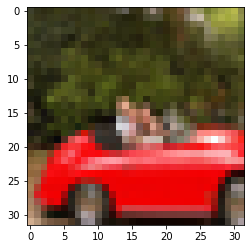

In [14]:
plt.imshow(img)
plt.show()

### Dataset Transforms

* Como es una imagen de PIL necesitamos una manera de convertirla a un tensor de PyTorch antes de poder hacer algo.
* Aqui entra el moduleo `torchvision.transforms`
    * funciones (objetos) componibles que pueden pasarse como un argumento a un dataset de `torchvision`
    * realizan las transformaciones sobre la data despues de cargarla pero antes de regresarla por `__getitem__`

In [15]:
from torchvision import transforms

dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

* Podemos ver que hay un metodo `ToTensor`
    * una vez instanciado puede ser llamado como funcion con la imagen PIL como argumento
    * retorna un tensor como output

In [16]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.size()

torch.Size([3, 32, 32])

La imagen se transformo a un tensor 3x32x32, por tanto es una imagen de 3 canales (RGB) y 32x32

Podemos pasar el transform directo como un argumento al `dataset.CIFAR10`

In [17]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                  transform=transforms.ToTensor())

Luego de esto, accesar un elemento del dataset va a retornar un tensor en vez de una imagen PIL:

In [18]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

Como esperado, la forma tiene el canal como primera dimension, mientras que el tipo de escalar es `flaot32`

In [19]:
img_t.size(), img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

* Los valores de la imagen PIL original tenian un rango [0,255] (8-bit por canal)
* El transform `ToTensor` cambio la data a 32-bit floating point por canal
* escalo los valores a [0.0, 1.0]

In [20]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

Verifiquemos que es la misma imagen:

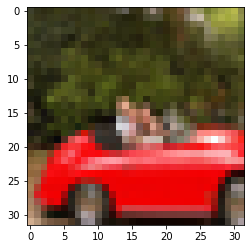

In [21]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

Lo es, pero tuvimos que usar `permute` para cambiar el orden de los ejes de CxHxW a HxWxC para pasarle a Matplotlib las dimensiones en el orden que las espera.

### Normalizar la data

* Los transforms son utiles porque podemos encadenar varios usando `transforms.Compose`
    * De esta forma podemos manejar la normalizacion y la aumentacion de data de forma transparente y directa en el data loader
* Por ejemplo, es buena practica normalizar el dataset para que cada canal tenga $\mu = 0$ y $\sigma = 1$
    * Si escogemos funciones de activacion que son lineales alrededor de 0 +- 1 (o 2), mantener la data en el mismo rango quiere decir que es mas probable que las neuronas tengan gradientes $\neq 0$ y por tanto van a aprender antes.
    * Asimismo, normalizar cada canal para que tenga la misma distribucion va a asegurar que la informacion del cana puede ser mezclada y actualizada con gradient descent usando el mismo learning rate.

Como CIFAR-10 es pequenio, podemos manipular todo en memoria. Vamos a apilar todos los tensores en el dataset a lo largo de una dimension extra:

In [22]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.size()

torch.Size([3, 32, 32, 50000])

Ahora podemos calcular la media por canal:

In [26]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4915, 0.4823, 0.4468])

Lo mismo para la desviacion estandar

In [28]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

Con estos numeros podemos inicializar la tranformacion `Normalize`

In [29]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

Y concatenarlo luego del transform `ToTensor`

In [31]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                      transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                               (0.2470, 0.2435, 0.2616))
                                      ]))

In [32]:
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

Noten que, despues de esto, plotear una imagen del dataset no nos va a proveer con una buena representacion de la imagen actual:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


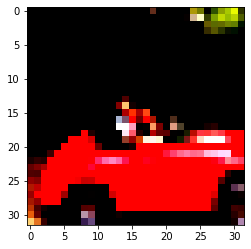

In [33]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1,2,0))
plt.show()

Esto es porque la normalizacion ha cambiado los niveles de RGB fuera del rango [0.0, 1.0] y tambien las magnitudes generales de los canales.

Toda la data sigue ahi, es solo que Matplotlib la representa como negra.

### Creando el dataset

* El primer paso es tener la data en la forma correcta.
* Podriamos hacer una sublcase que solo incluya pajaros y aviones
* En vez de eso, la solucion facil es filtrar la data en `cifar10` y remapear las etiquetas

In [34]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

## El uso de Convolutions

* Un modelo lineal entrenado en imagenes tiende a overfit el training set por la configuracion de fully connected layers
* Necesita detectar varias posibles traslaciones de objetos en la imagen
    * Esto necesita mucho parametros
    * lo que causa que se mas facil para el modelo memorizar el training set
* No hay independencia de la posicion
    * Hace que generalizar sea mas dificil

**Hay una mejor manera**

* Reemplazar las fully connected layers de la NN con una operacion lineal diferente: convolutions
* `nn.Linear`: Tomar una vista 1D de una imagen y multiplicarla con una weight matrix de `n_output_features x n_input_features`
    * tomar todos los pixeles de la imagen y, por cada canal calcular la suma ponderada de todos los pixeles multiplicados por un set de weights, uno por output feature.
* Si queremos reconocer patrones correspondientes a un objeto, necesitamos ver como estan arreglados pixeles cercanos
    * Y estariamos menos interesados en en como pixeles separados aparecen en combinacion.
* En esencia, no importa si la imagen con el objeto que queremos detectar tiene un arbol, nube, carro en la esquina o no

* Para trasladar esta intuicion a forma matematica podriamos:
    * calcular la suma ponderada de cada pixel con sus vecinos inmediatos, en vez de con todos los otros pixeles.
    * Esto seria equivalente a construir weight matrices, una por output feature y ubicacion del output pixel.
    * En este caso todos los weights despues de cierta distancia de un pixel central serian cero.
* Hay una ultima propiedad deseada: 
    * queremos que estos patrones localizados tengan un efecto en el output sin importar su ubicacion en la imagen
    * esto se llama translation-invariant.

### Entonces que es una convolution?

Una convolution, o mas preciso una convolution discreta (hay una version continua), se define para una imagen de 2D como el producto escalar de un weight matrix, llamado el _kernel_, con todos los vecinos en el input. 

Consideren un kernel de 3x3 (en deep learning se acostumbra a usar kernels pequenios) como un tensor 2D:

In [ ]:
weight = torch.tensor([w00, w01, w02],
                      [w10, w11, w12],
                      [w20, w21, w22])

y una imagen MxN de 1 canal:

In [ ]:
image = torch.tensor([[i00, i01, i02, i03, ..., i0N],
                      [i10, i11, i12, i13, ..., i1N],
                      [i20, i21, i22, i23, ..., i2N],
                      [i30, i31, i32, i33, ..., i3N],
                      ...
                      [iM0, iM1, iM2, iM3, ..., iMN]])

Podemos calcular un elemento de la imagen de output (sin bias) como:

In [ ]:
o11 = i11 * w00 + i12 * w01 + i22 * w02 +
      i21 * w10 + i22 * w11 + i23 * w12 +
      i31 * w20 + i32 * w21 + i33 * w22

### DIBUJO

* Es decir, estamos "trasladando" el kernel en la ubicacion `i11` del input image, y multiplicamos cada peso con el valor de input image en su ubicacion correspondiente.
* Por tanto, el output image es creada al trasladar el kernel sobre todas las ubicaciones del input y realizar una suma ponderada.
* Para imagenes multi-canal, como nuestras imagenes RGB, el weight matrix seria una matriz 3x3x3,
    * i.e. un set de weights por cada canal, contribuyendo en conjunto a los valores del output

* Notese que el mismo kernel, y por tanto cada weight en el kernel, es reusado a traves de toda la imagen.
* Pensando de regreso al Autograd:
    * esto quiere decir que el uso de cada weight tiene una historia que incluye la imagen entera.
    * por tanto, la derivada del los w.r.t a un convolution weight incluye contribuciones de la imagen entera.

Entonces, una convolution es equivalente a aplicar multiples operaciones lineales, cuyos pesos son cero casi en todos lados excepto alrededor de pixeles individuales y reciben actualizaciones equivalentes durante el entrenamiento.

### En resumen:

Al cambiar a convolutions optuvimos:
* operaciones locales sobre vecinos
* translation-invariance
* modelos con mucho menos parametros

El insight clave en el tercer punto es que, con una convolution layer, el numero de parametrso no depende en el numero de pixeles en la imagen, como lo hace en un modelo fully connected.

Depende en el convolution kernel (3x3, 5x5, etc) y en cuantos convolution filters (o output channels) decidimos usar en nuestro modelo.

## Convolutions en accion